<a href="https://colab.research.google.com/github/ge43jef/GEEHYDRO/blob/perfectdatacodes/NNregression_workingfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 11.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchmetrics.classification import MulticlassAccuracy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
from glob import glob

files = glob('FLX*')

dataframes = []

columns_to_read = ["SW_IN_F","LW_IN_F", "PA_F", "WS_F", "VPD_F", "temperature_2m", "total_precipitation_sum", "LE_CORR"]

for file in files:
    df = pd.read_excel(file, usecols=columns_to_read, header=0)  # Replace read_excel with the appropriate function for your file format
    dataframes.append(df)

# Concatenate all the DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df

,SW_IN_F,LW_IN_F,VPD_F,PA_F,WS_F,LE_CORR,temperature_2m,total_precipitation_sum
0,103.330,295.435,0.803,99.659,1.033,14.0894,279.555888,8.320000e-05
1,120.125,272.751,1.355,100.435,1.093,20.2355,278.457296,5.820000e-04
2,116.812,284.339,2.715,100.976,0.823,18.9021,278.608387,4.410000e-07
3,37.592,309.736,1.482,100.996,0.680,13.4714,279.167382,1.650000e-04
4,123.604,264.920,4.161,100.458,1.685,19.5968,280.145327,3.000000e-06
...,...,...,...,...,...,...,...,...
17525,96.744,257.042,1.750,102.643,0.971,29.0690,280.321662,0.000000e+00
17526,117.460,268.529,2.464,102.492,0.638,29.7458,280.833206,8.550000e-07
17527,65.695,276.439,1.255,102.092,1.195,23.5720,280.310670,9.610000e-05
17528,133.985,237.433,4.854,102.059,7.740,46.6856,280.379863,1.010000e-05


In [4]:
count_9999 = (combined_df["LE_CORR"] == -9999).sum()
print("Number of values with -9999 in LE_CORR:", count_9999)

combined_df = combined_df[combined_df["LE_CORR"] != -9999]

Number of values with -9999 in LE_CORR: 121


In [54]:
def normalization(x):
    x= (x-min(x)) / (max(x) - min(x))
    return x

In [55]:
X = combined_df.drop("LE_CORR", axis=1)
y = combined_df["LE_CORR"]

In [62]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [63]:
X=X.values

In [64]:
y = y.values

In [65]:
for i in np.arange(7):
    X[: , i] = normalization(X[:,i])

In [66]:
y =normalization(y)

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [68]:
class MLP_regree(nn.Module):
    '''
      Multilayer Perceptron for classification.
    '''

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(7, 12),
            nn.ReLU(),
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.ReLU(),
            nn.Linear(7, 1),

        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [69]:
class Dataset(torch.utils.data.Dataset):
    '''
    Prepare the dataset for neural network
    '''

    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary

            self.X = torch.from_numpy(X).type(torch.float)
            self.y = torch.from_numpy(y).type(torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [70]:
if __name__ == '__main__':

    # Set fixed random number seed
    torch.manual_seed(4078)
    dataset = Dataset(X_train, y_train)
    trainloader = DataLoader(dataset, batch_size = 500 , shuffle=True)
    mlp = MLP_regree()

    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.0001)

    # Run the training loop
    for epoch in range(0, 1000):

        # Print epoch
        print(f'Starting epoch {epoch + 1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
            # Get and prepare inputs
            inputs, targets = data
            #inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))

            # Zero the gradients
            optimizer.zero_grad()
            outputs = mlp(inputs)
            loss = loss_function(outputs , targets )

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
           # current_loss += loss.item()
           # if (i+1) % 10 == 0:
              #  print('Loss after mini-batch %5d: %.3f' %
             #         (i + 1, loss.item()))
             #   current_loss = 0.0

    # Process is complete.
    print('Training process has finished.')

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

In [71]:
dataset = Dataset(X_test, y_test)
testloader = DataLoader(dataset, batch_size = len(dataset))

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
         # Get and prepare inputs
        inputs, targets = data
        output = mlp(inputs)
        output = torch.reshape(output, (-1,))
        loss = loss_function(output,targets)

print('MSE: '+ str(loss.item()))

MSE: 0.006313193589448929


<Figure size 640x480 with 0 Axes>

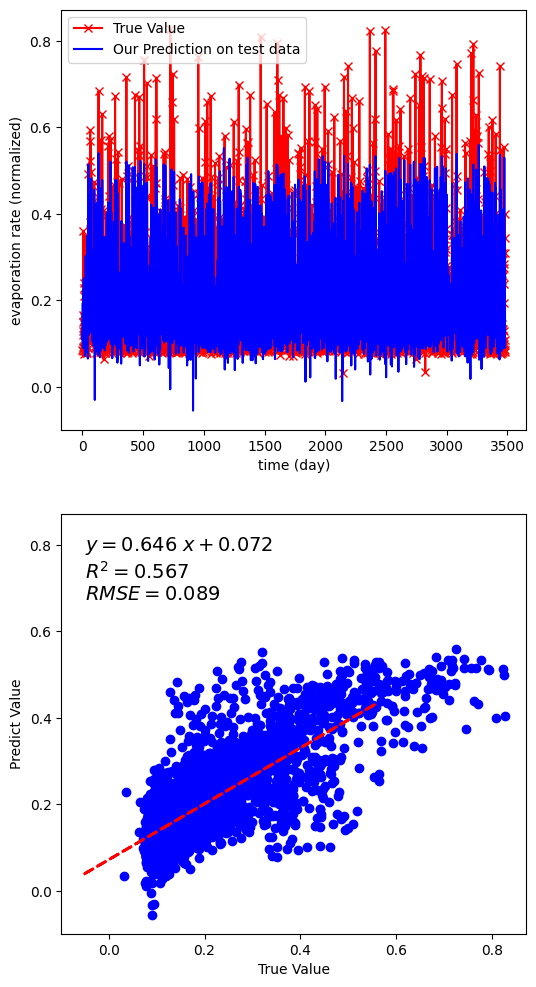

In [72]:
# plot the data
# Plot the data points
fig = plt.figure()
fig,ax=plt.subplots(2, 1, figsize=(6, 12), sharey=True)
ax[0].plot( y_test, marker='x', c='r',label='True Value')
ax[0].plot( output , c='b',label='Our Prediction on test data')
ax[0].set(xlabel="time (day)", ylabel="evaporation rate (normalized)")
ax[1].scatter( y_test , output.flatten() , c='b')
z = np.polyfit(y_test , output.flatten() , 1)
y_hat = np.poly1d(z)(output)
plt.plot(output.flatten(), y_hat, "r--", lw=2)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y_test, y_hat):0.3f}$\n" \
                   f"$RMSE = {mean_squared_error(y_test, y_hat, squared=False):0.3f} $ "
plt.gca().text(0.05, 0.95, text, transform=plt.gca().transAxes,
                           fontsize=14, verticalalignment='top')
plt.ylabel('Predict Value')
# Set the x-axis label
plt.xlabel('True Value')
ax[0].legend()
plt.show()